In [1]:
# === Bootstrap Coverage (HDR) Silhouettes from 3D Points (2 states) ===
# Inputs: two CSVs with ['middle_x','middle_y','middle_z']
# Outputs:
#   - proj_XY.png, proj_YZ.png, proj_XZ.png
#   - density_A_[XY|YZ|XZ].npy / density_B_[XY|YZ|XZ].npy
#   - support_A_[XY|YZ|XZ].npy / support_B_[XY|YZ|XZ].npy   
#   - overlay_[XY|YZ|XZ]_bands_hdr.png
#   - overlay_[PLANE]_pXX_hdr.png for XX in [100,99,98,97,96,95,90,80,60,50]
#   - overlay_[PLANE]_p100_support.png                      
#   - metrics_hdr.csv  (now includes a 'variant' column: 'hdr' or 'support')
# Notes:
#   - mass_levels are coverage fractions (1.0 == ~100% of projected points)
#   - n_boot higher (300–500) -> smoother densities
#   - density_floor_frac zeros tiny tails before HDR thresholding

import os, json, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from skimage.measure import find_contours

np.set_printoptions(suppress=True)

# Config with default values
# pipeline will use these values unless other values are provided in the main function
@dataclass
class Cfg:
    grid_base: int = 160
    pad_frac: float = 0.05
    sigma_vox: float = 3.0
    q_metaball: float = 0.90
    min_blob_vox: int = 200
    post_close: int = 1

    # Bootstrap for density averaging
    n_boot: int = 256
    sample_frac: float = 1.0      # draw n with replacement if 1.0

    # Coverage (HDR) levels
    mass_levels: Tuple[float, ...] = (1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50)

    # 2D density smoothing (pixels of the 2D hist grid)
    sigma_px: float = 1.2

    # Tail trimming for HDR (zeros tiny densities before threshold search)
    density_floor_frac: float = 0.002  # set 0.0 to disable

    # Support-based p100 option
    use_support_p100: bool = True
    support_min_hits: int = 1   # bin must be hit in at least this many bootstraps

    # Alignment (PCA + robust ICP)
    # fraction of worst matches to ignore in each ICP iteration
    # at most 0.5 (0.0 = use all points)
    trim_q: float = 0.10
    # number of ICP iterations
    # error usually stabilizes after ~20
    icp_iters: int = 30 # use ~50 for more difficult cases
    # max points to sample from each set for ICP (None = use all)
    sample_icp: int = 50000

    out_dir: str = "out_boot_coverage_2state"

# IO
def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

# Alignment
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]] # sort eigenvectors by descending eigenvalues
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1 # enforce right-handedness
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1) # distance from each B to nearest A and vice versa
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean())) 
    return rmse

# Find the best PCA-based alignment (rotation matrix) of B onto A
# by testing all axis permutations & sign flips, keeping the one with lowest RMSE.
def best_pca_prealign(B_pts, A_pts):
    # get PCA axes
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    # identity matrix
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            # Orthogonal Procrustes Problem
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

# Kabsch rigid alignment from point set Q-->P (compute rotation + translation).
# Note: this implementation returns a transform used later as Q @ R.T + t.
# See https://en.wikipedia.org/wiki/Kabsch_algorithm
# given two sets of paired points P and Q
# Kabsch finds the best rotation R and translation t that makes them overlap as closely as possible
# it does without scaling so distances and shapes stay the same
def kabsch(P, Q):
    # center both sets of points at the origin
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    # compute covariance matrix
    H = Q0.T @ P0
    # SVD = Singular Value Decomposition
    U, S, Vt = np.linalg.svd(H)
    # compute rotation
    R = Vt.T @ U.T
    # ensure a right-handed coordinate system (no reflection)
    if np.linalg.det(R) < 0:
        # flip the last singular vector
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    # compute translation
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    # random number generator
    rs = np.random.default_rng(seed)
    # if sample <= len(pts), use all points
    # else randomly sample without repeat (each points can only be chosen once)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    
    # identity matrix for rotation, zero vector for translation
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        # Apply the current transform
        Bx = B @ R.T + t
        # Find nearest neighbors
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        # Discard a fraction of worst matches (trim outliers)
        if 0.0 < trim_q < 0.5:
            # keep only the best (1-trim_q) fraction of matches
            thr = np.quantile(d, 1 - trim_q)
            # build a mask of which matches to keep (True/False)
            keep = d <= thr
            # apply the mask
            P, Bx = P[keep], Bx[keep]
        # compute optimal rigid transform on the remaining matches
        # we have P (from A) and Bx (transformed B) pairs
        # we need to find best rotation + shift that brings B onto A
        R_upd, t_upd = kabsch(P, Bx)
        # update the overall transform (order matters!)
        # combine new rotation with previous rotation
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# Grid 
def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    # find min and max along each axis (x, y, z)
    # This gives the bounding box of all points P
    mn, mx = P.min(0), P.max(0)
    # Compute the extent = size of the box in each dimension
    ext = mx - mn
    # add padding, expand both min and max by this pad amount
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    # decide how finely to scale the grid
    # base = target size of the longest axis (e.g. 160)
    scale = base / float(ext.max() + 1e-8)
    # compute the number of bins (voxels) along each axis
    # clamp to [32, 512] to avoid too coarse or too fine grids
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    # compute the bin edges along each axis
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

# 2D densities (HDR) 
PLANE_FROM_AXIS = {'z': 'XY', 'x': 'YZ', 'y': 'XZ'}
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}   # which coords to project

# Bootstrap 2D densities + support counts
# resample points many times with replacement
# smooth them onto the shared grid to see where points consistently fall
# from this probability map extract regions that are always there (high-density contours)
def boot_density_and_support_2d(P: np.ndarray, edges3d, cfg: Cfg):
    """
    Average 2D densities over bootstrap resamples AND accumulate per-bin support counts.
    Returns two dicts: Densities 'x|y|z' -> [ny,nx] float, Supports 'x|y|z' -> [ny,nx] bool
    """
    # which 2D plane corresponds to which axes
    xed, yed, zed = edges3d
    plane_edges = {
        'z': (xed, yed),   # XY
        'x': (yed, zed),   # YZ
        'y': (xed, zed),   # XZ
    }
    # accumulators for density sums and support counts
    accD = {a: None for a in ('x','y','z')}
    accC = {a: None for a in ('x','y','z')}   # counts of resamples with hits
    # number of points to sample in each bootstrap resample
    n = len(P); k = max(1, int(round(cfg.sample_frac * n)))
    # random number generator
    rs = np.random.default_rng(0)

    for _ in range(cfg.n_boot):
        # pick k points with replacement
        idx = rs.integers(0, n, size=k)  # with replacement
        sub = P[idx]
        for a in ('x','y','z'):
            # take two coords indices
            i, j = AXPAIR[a]
            ex, ey = plane_edges[a]
            # 2D histogram
            H, _, _ = np.histogram2d(sub[:, i], sub[:, j], bins=[ex, ey])  # shape [nx, ny]
            # density (smoothed) gaussian filter
            D = gaussian_filter(H.astype(np.float32), sigma=cfg.sigma_px)
            # transpose to standard orientation [rows, cols] = [y, x]
            D = D.T  # -> [ny, nx]
            # accumulate density across bootstraps
            if accD[a] is None: accD[a] = D
            else: accD[a] += D
            # support count (raw hits before smoothing)
            # mark which bins were hit at all (true/false)
            S = (H > 0).T  # -> [ny, nx] boolean hits for this resample
            if accC[a] is None: accC[a] = S.astype(np.uint16)
            else: accC[a] += S.astype(np.uint16)

    # average density maps across bootstraps
    outD = {a: (accD[a] / float(cfg.n_boot)) if accD[a] is not None else None for a in accD}
    # support maps (which bins were hit in ≥ support_min_hits bootstraps).
    outS = {a: (accC[a] >= cfg.support_min_hits) if accC[a] is not None else None for a in accC}
    return outD, outS

# Density thresholding & contours
def apply_density_floor(D: np.ndarray, frac: float) -> np.ndarray:
    # zero out tiny densities below a fraction of the max density
    if frac <= 0: return D
    # fraction of max density
    eps = float(frac) * float(D.max() if np.isfinite(D.max()) else 0.0)
    # if the fraction is too small, return the original array
    if eps <= 0: return D
    # otherwise zero out values below eps
    Df = D.copy()
    Df[Df < eps] = 0.0
    return Df

def mass_threshold(D: np.ndarray, mass: float) -> float:
    """
    Return density threshold (tau) so that sum(D[D>=tau]) ≈ mass * sum(D).
    Special-case mass=1.0 -> choose the smallest strictly positive tau to include all positive density.
    """
    # make density map 1-D so its easy to sort and sum
    flat = D.ravel()
    # total density in the map
    # if zero/negative/NaN, return inf
    s = flat.sum()
    if s <= 0: return float('inf')
    # special case for p100 : take the smallest positive density value
    # so that all positive density is included
    # if no positive values, return inf
    if mass >= 0.999999:
        pos = flat[flat > 0]
        return float(pos.min()) if pos.size else float('inf')
    # sort densities in descending order (highest to lowest)
    v = np.sort(flat)[::-1]
    # cumulative sum of sorted densities
    c = np.cumsum(v)
    # target total = mass * (total density)
    # find the smallest index where cumulative sum >= target total
    # return the density value at that index as the threshold
    return float(v[np.searchsorted(c, mass * c[-1], side='left')])

# find contour at given mass level
def contour_at_mass(D: np.ndarray, mass: float) -> Optional[np.ndarray]:
    # get the cutoff tau, if tau is inf or NaN, return None
    tau = mass_threshold(D, mass)
    if not np.isfinite(tau): return None
    # Use skimage.measure.find_contours to trace level-tau isolines on the 2D array.
    # returns a list of polylines (each is [N,2] as [row,col])
    cs = find_contours(D, level=tau)  # D is [rows, cols]
    # if no contours found, return None
    if not cs: return None
    # Sort by number of points (proxy for length) and keep the longest contour (main silhouette).
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# find contour from boolean mask
def contour_from_bool(M: np.ndarray) -> Optional[np.ndarray]:
    if M is None or M.sum() == 0: return None
    # find contours at level 0.5 (between False=0 and True=1)
    cs = find_contours(M.astype(float), level=0.5)
    if not cs: return None
    # return the longest contour
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# Plotting
def save_point_projection_like_screenshot(A, B, i, j, plane, out_dir,
                                          labelA="A", labelB="B"):
    # helper that plots a 2D projection of two point sets A and B and saves it
    all2 = np.vstack([A[:,[i,j]], B[:,[i,j]]])
    # find the min and max along each axis across both sets
    # to get overall rectangle that contains everything
    (xmin,ymin) = all2.min(0); (xmax,ymax) = all2.max(0)
    # compute the range on X and Y axes
    xr, yr = (xmax-xmin), (ymax-ymin); pad = 0.02
    fig, ax = plt.subplots(figsize=(5,4))
    # ligh gray
    ax.set_facecolor("#f0f0f0")
    # plot set A with blue +
    ax.scatter(A[:, i], A[:, j], marker="+", s=8, linewidths=0.6,
               alpha=0.85, c="#1f77b4", label=labelA)
    # plot set B with red x
    ax.scatter(B[:, i], B[:, j], marker="x", s=8, linewidths=0.6,
               alpha=0.75, c="#d62728", label=labelB)
    # set limits with a bit of padding
    ax.set_xlim(xmin - pad*xr, xmax + pad*xr)
    ax.set_ylim(ymin - pad*yr, ymax + pad*yr)
    # equal aspect ratio, no ticks
    ax.set_aspect("equal","box"); ax.set_xticks([]); ax.set_yticks([])
    # title and legend
    ax.set_title(plane); ax.legend(loc="upper left", fontsize=8, frameon=True)
    # save
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"proj_{plane}.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

def save_overlay_mass_level(DA, DB, mass, axis, out_dir, labelA, labelB):
    # helper that plots an overlay of two densities DA and DB at a given mass level
    plane = PLANE_FROM_AXIS[axis]
    # plot
    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    # light gray background where either density is positive
    ax.imshow(((DA>0) | (DB>0)), cmap="gray", alpha=0.12)
    # draw contours for each density
    for D, color, lab in [(DA, "#1f77b4", labelA), (DB, "#d62728", labelB)]:
        # find contour at the given mass level
        C = contour_at_mass(D, mass)
        # if found, plot it
        if C is not None:
            ax.plot(C[:,1], C[:,0], '-', lw=2.4, color=color, alpha=0.95,
                    label=f"{lab} HDR {int(round(mass*100))}%")
    ax.set_title(f"{plane} — HDR {int(round(mass*100))}%")
    ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"overlay_{plane}_p{int(round(mass*100))}_hdr.png"),
                dpi=220, bbox_inches="tight")
    plt.close(fig)

# Support-based p100 overlay
def save_overlay_support_p100(SA_bool, SB_bool, axis, out_dir, labelA, labelB):
    # helper that plots an overlay of two support masks SA_bool and SB_bool
    plane = PLANE_FROM_AXIS[axis]
    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    ax.imshow((SA_bool | SB_bool), cmap="gray", alpha=0.12)
    # find contours
    CA = contour_from_bool(SA_bool); CB = contour_from_bool(SB_bool)
    if CA is not None:
        ax.plot(CA[:,1], CA[:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95,
                label=f"{labelA} support p100")
    if CB is not None:
        ax.plot(CB[:,1], CB[:,0], '-', lw=2.4, color="#d62728", alpha=0.95,
                label=f"{labelB} support p100")
    ax.set_title(f"{plane} — support p100 (union of hits)")
    ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"overlay_{plane}_p100_support.png"),
                dpi=220, bbox_inches="tight")
    plt.close(fig)

# Metrics 
# Intersection-over-Union (IoU) for boolean masks
def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    # if either is None or empty, return NaN
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

# Contour distances (mean nearest neighbor + Hausdorff)
# using cKDTree for fast nearest neighbor search
def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]) -> Tuple[float,float]:
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

# Main
def run_bootstrap_coverage(csv_A: str, csv_B: str, cfg=Cfg(), labelA=LABEL_A, labelB=LABEL_B):
    os.makedirs(cfg.out_dir, exist_ok=True)

    # 1) load & center
    A_raw, B_raw = load_points(csv_A), load_points(csv_B)
    # center both at 0, 0, 0
    # mean(0) -> avg each column
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)

    # 2) align B->A (best-PCA, then ICP)
    Rpre = best_pca_prealign(B0, A0)
    # apply pre-align
    B1 = B0 @ Rpre.T
    # refine with robust ICP
    # TODO: may not needed for our case
    # TODO: how to identify the appropiate sample size? 
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters, sample=cfg.sample_icp, trim_q=cfg.trim_q)
    # apply ICP
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)

    #### silhouette analysis ####
    # 3) uniform scale (shared bbox)
    # minimum and maximum XYZ across both sets
    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    # Compute the size of that bounding box along each axis
    s = float((maxs - mins).max())
    # Divide all coordinates by s
    # this scales both point clouds into the same unit cube
    # fits within [-1,1] or [0,1], depending on origin
    A = A_al/s; B = B_al/s

    # 4) shared 3D grid (for consistent 2D edges) + 2D densities & supports via bootstrap
    # creates a global 3D grid that fits both sets of points
    edges3d, _ = make_grid_from_bounds(np.vstack([A, B]), base=cfg.grid_base, pad_frac=cfg.pad_frac)
    # 2D densities & supports via bootstrap
    DensA, SuppA = boot_density_and_support_2d(A, edges3d, cfg)   # dict 'x','y','z' -> [ny,nx]
    DensB, SuppB = boot_density_and_support_2d(B, edges3d, cfg)

    # 5) save point projections (XY, YZ, XZ)
    save_point_projection_like_screenshot(A, B, 0, 1, "XY", cfg.out_dir, labelA, labelB)
    save_point_projection_like_screenshot(A, B, 1, 2, "YZ", cfg.out_dir, labelA, labelB)
    save_point_projection_like_screenshot(A, B, 0, 2, "XZ", cfg.out_dir, labelA, labelB)

    # 6) save densities/supports & overlays
    # store all metrics as a list of dicts
    metrics_rows = []
    # for each plane
    for a in ('x','y','z'):
        # skip if either density is None
        if DensA[a] is None or DensB[a] is None:
            continue
        # which plane (e.g., 'z' → "XY", 'y' → "XZ", `'x' → "YZ"'
        plane = PLANE_FROM_AXIS[a]

        # densities (raw)
        # save as .npy for possible later use
        np.save(os.path.join(cfg.out_dir, f"density_A_{plane}.npy"), DensA[a])
        np.save(os.path.join(cfg.out_dir, f"density_B_{plane}.npy"), DensB[a])
        # supports (boolean) -- save if available
        if SuppA[a] is not None: np.save(os.path.join(cfg.out_dir, f"support_A_{plane}.npy"), SuppA[a])
        if SuppB[a] is not None: np.save(os.path.join(cfg.out_dir, f"support_B_{plane}.npy"), SuppB[a])

        # densities with floor (for nicer HDR contours)
        DA = apply_density_floor(DensA[a], cfg.density_floor_frac)
        DB = apply_density_floor(DensB[a], cfg.density_floor_frac)

        # per-level HDR overlays + metrics
        for m in cfg.mass_levels:
            # draw and save overlay
            save_overlay_mass_level(DA, DB, m, a, cfg.out_dir, labelA, labelB)

            ## measuring the differences numerically
            # Find the density cutoff (tau) for A and B that encloses m × 100% of the mass.
            tauA = mass_threshold(DA, m)
            tauB = mass_threshold(DB, m)
            # Turn the density maps into binary masks (inside vs outside the silhouette) for A and B
            MA = (DA >= tauA); MB = (DB >= tauB)
            # Compute Intersection-over-Union (IoU) between the two masks
            # how much they overlap (0 = no overlap, 1 = perfect overlap).
            IoU = iou_bool(MA, MB)
            # Extract the contour lines (the actual silhouette boundaries) from A and B.
            CA = contour_at_mass(DA, m); CB = contour_at_mass(DB, m)
            # Measure how far apart the contours are
            # Mean Nearest Neighbor distance (average distance from points on one contour to the other)
            # and Hausdorff distance (the maximum distance from points on one contour to the other
            mnn, haus = contour_distances(CA, CB)
            # store metrics
            metrics_rows.append(dict(plane=plane, level=int(round(m*100)), variant="hdr",
                                     IoU=IoU, meanNN=mnn, Hausdorff=haus))

        # support-based p100 (union of hits), overlays + metrics
        if cfg.use_support_p100 and (SuppA[a] is not None) and (SuppB[a] is not None):
            # save overlay
            save_overlay_support_p100(SuppA[a], SuppB[a], a, cfg.out_dir, labelA, labelB)
            # Compute Intersection-over-Union between the support masks
            IoU_s = iou_bool(SuppA[a], SuppB[a])
            # Extract the contour lines from the support masks for A and B
            CA_s = contour_from_bool(SuppA[a]); CB_s = contour_from_bool(SuppB[a])
            # Measure how far apart the support contours are (meanNN, Hausdorff)
            mnn_s, haus_s = contour_distances(CA_s, CB_s)
            # store metrics
            metrics_rows.append(dict(plane=plane, level=100, variant="support",
                                     IoU=IoU_s, meanNN=mnn_s, Hausdorff=haus_s))

    # 7) save metrics & meta
    df = pd.DataFrame(metrics_rows).sort_values(["plane","level","variant"], ascending=[True, False, True])
    df.to_csv(os.path.join(cfg.out_dir, "metrics_hdr.csv"), index=False)

    meta = dict(csv_A=csv_A, csv_B=csv_B, label_A=labelA, label_B=labelB, cfg=cfg.__dict__,
                note="2D HDR coverage per view from bootstrapped densities; optional support-based p100; PCA+ICP-aligned & scaled; density tail floor applied before HDR.")
    with open(os.path.join(cfg.out_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(df)
    print(f"Saved HDR overlays & metrics in: {cfg.out_dir}")

# run 
if __name__ == "__main__":
    # Labels for the two conditions (for plots)
    LABEL_A = "12 h — UNTR"
    LABEL_B = "12 h — VACV"
    CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
    CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"
    run_bootstrap_coverage(
        CSV_A, CSV_B,
        Cfg(
            grid_base=160, pad_frac=0.05,
            sigma_vox=3.0, q_metaball=0.90, min_blob_vox=200, post_close=1,
            n_boot=256, sample_frac=1.0,
            mass_levels=(1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50),
            sigma_px=1.2,
            density_floor_frac=0.002,   # try 0.001–0.005 if you still see bloated p100
            use_support_p100=True,      # also write overlay_*_p100_support.png
            support_min_hits=1,
            trim_q=0.10, icp_iters=30, sample_icp=50000,
            out_dir="data/green_monkey/va_testing/out_chr1_12h_untr_vs_vacv_hdr"
        ),
        labelA=LABEL_A, labelB=LABEL_B
    )


   plane  level  variant       IoU     meanNN  Hausdorff
22    XY    100      hdr  0.750930   5.081812  23.236215
32    XY    100  support  0.110418  16.102593  28.319605
23    XY     99      hdr  0.634577   5.255348  23.170830
24    XY     98      hdr  0.591358   5.758198  22.632893
25    XY     97      hdr  0.561441   5.111475  17.845996
26    XY     96      hdr  0.534387   5.420998  19.098822
27    XY     95      hdr  0.512989   5.262549  20.272934
28    XY     90      hdr  0.446524   5.073710  25.015234
29    XY     80      hdr  0.359690   6.463194  33.117883
30    XY     60      hdr  0.231888   3.122064  15.582034
31    XY     50      hdr  0.195914   6.132452  23.355832
11    XZ    100      hdr  0.668938   7.073854  32.738368
21    XZ    100  support  0.081689  31.694683  39.357337
12    XZ     99      hdr  0.569227   5.502179  20.041952
13    XZ     98      hdr  0.525391   5.406968  19.609260
14    XZ     97      hdr  0.494376   5.590879  26.672766
15    XZ     96      hdr  0.468

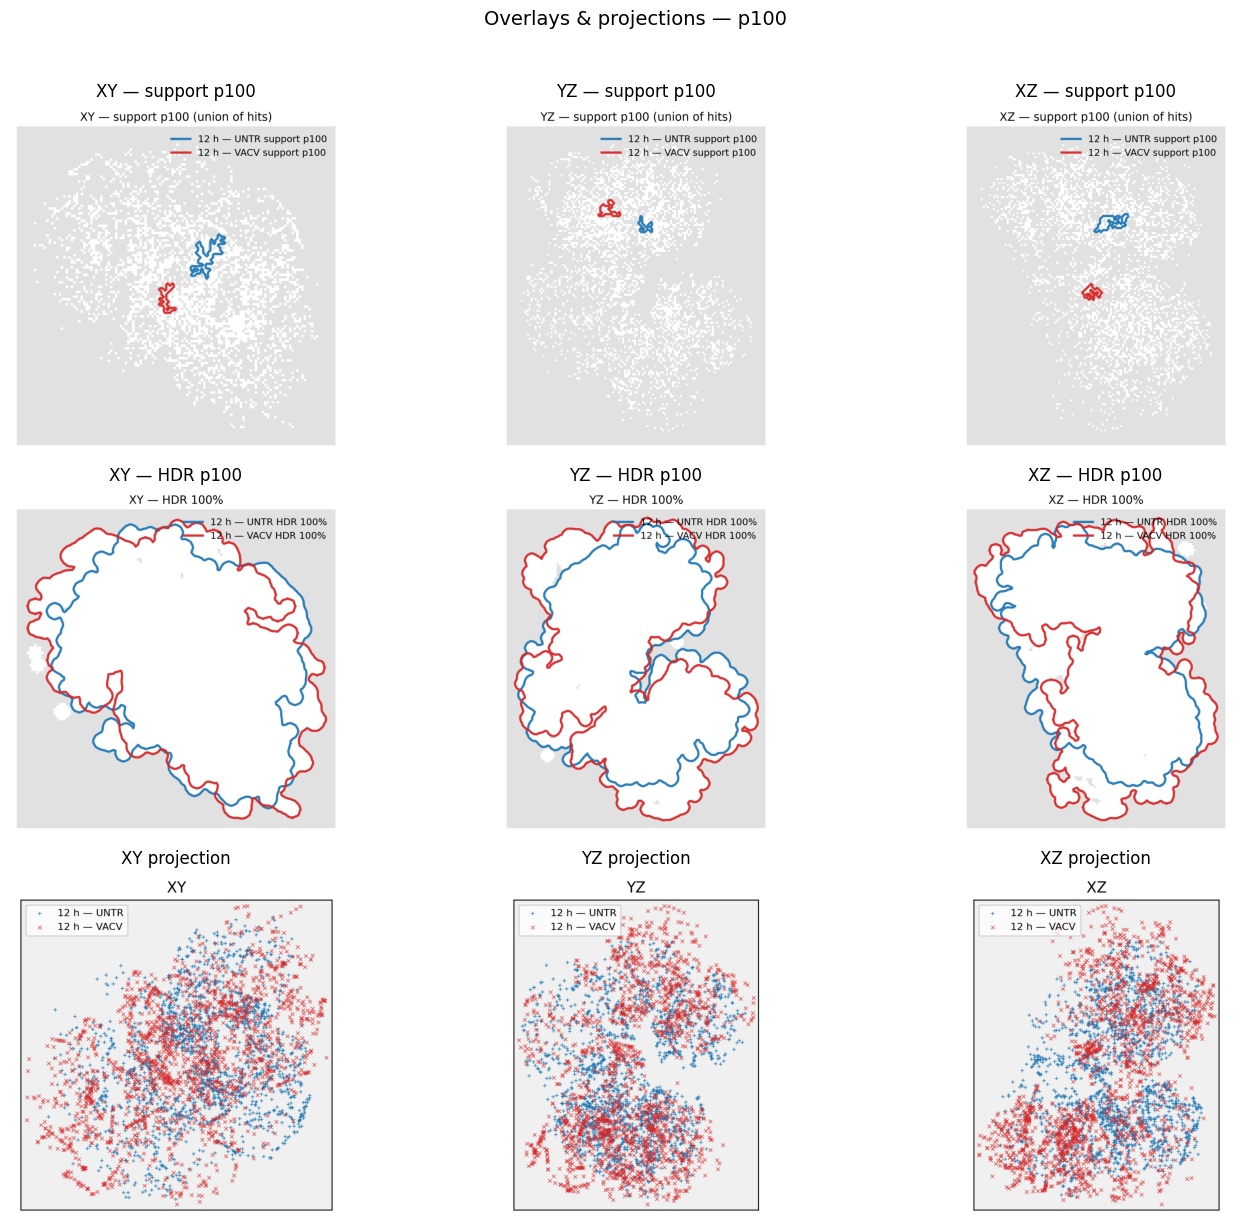

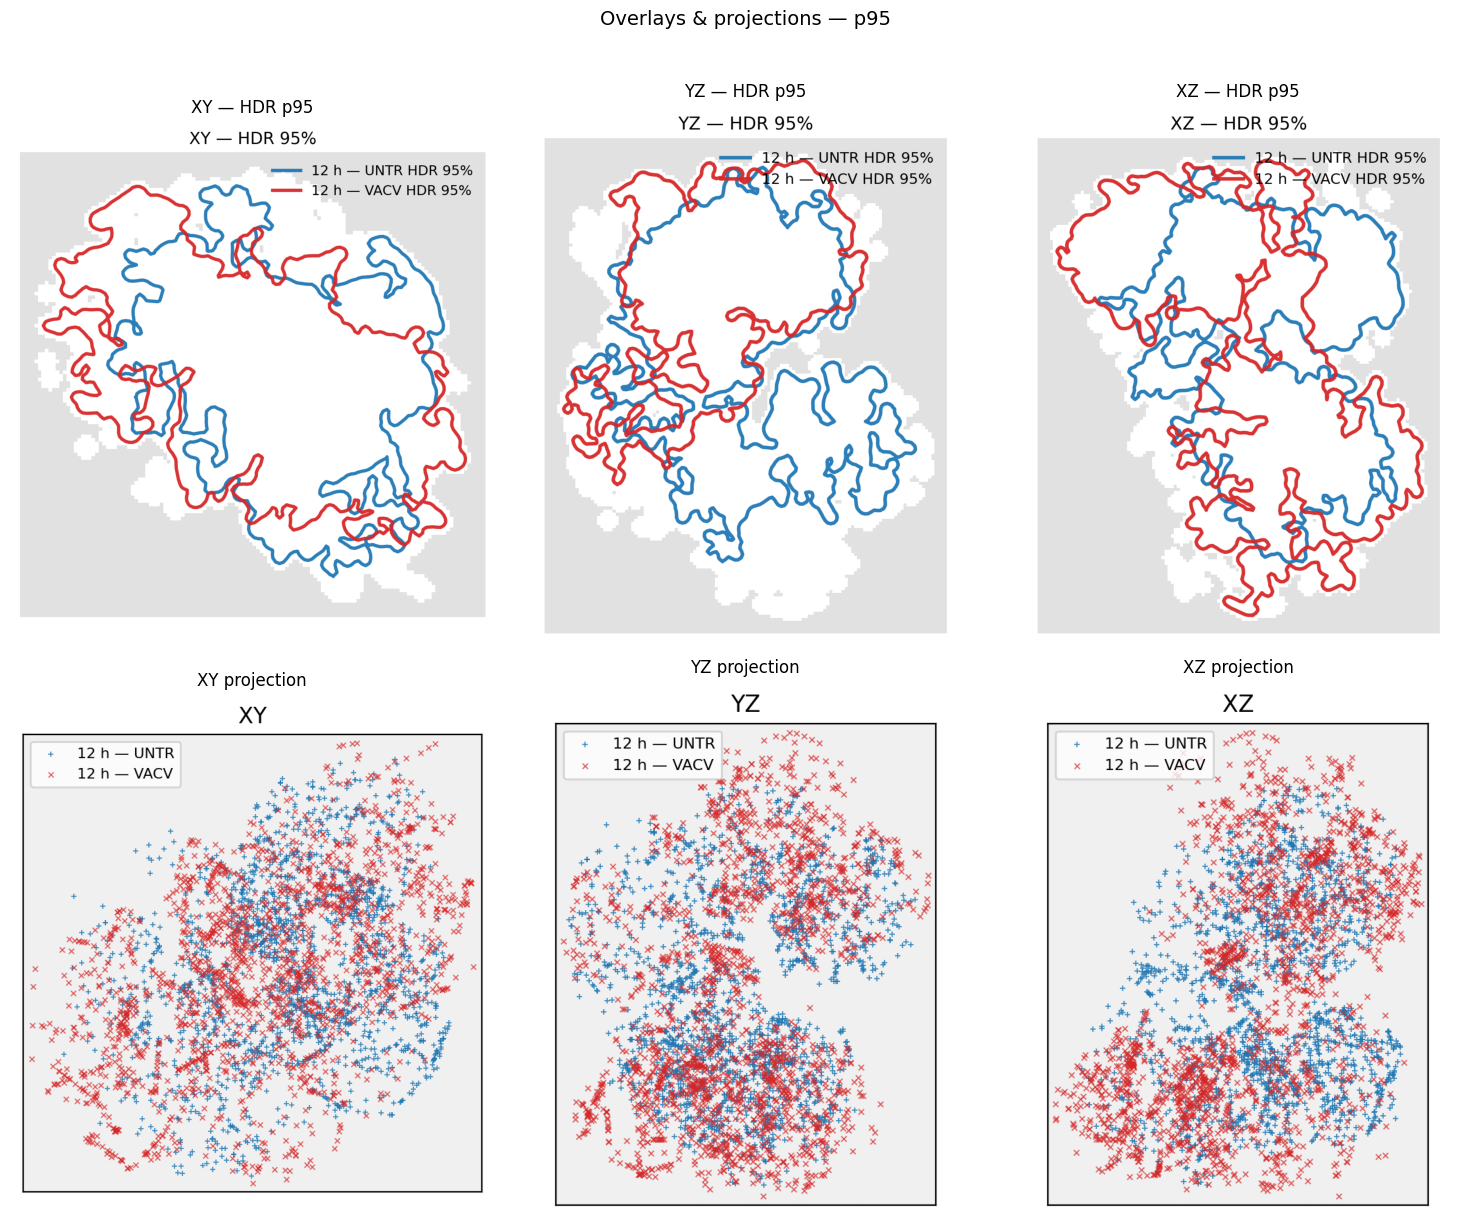

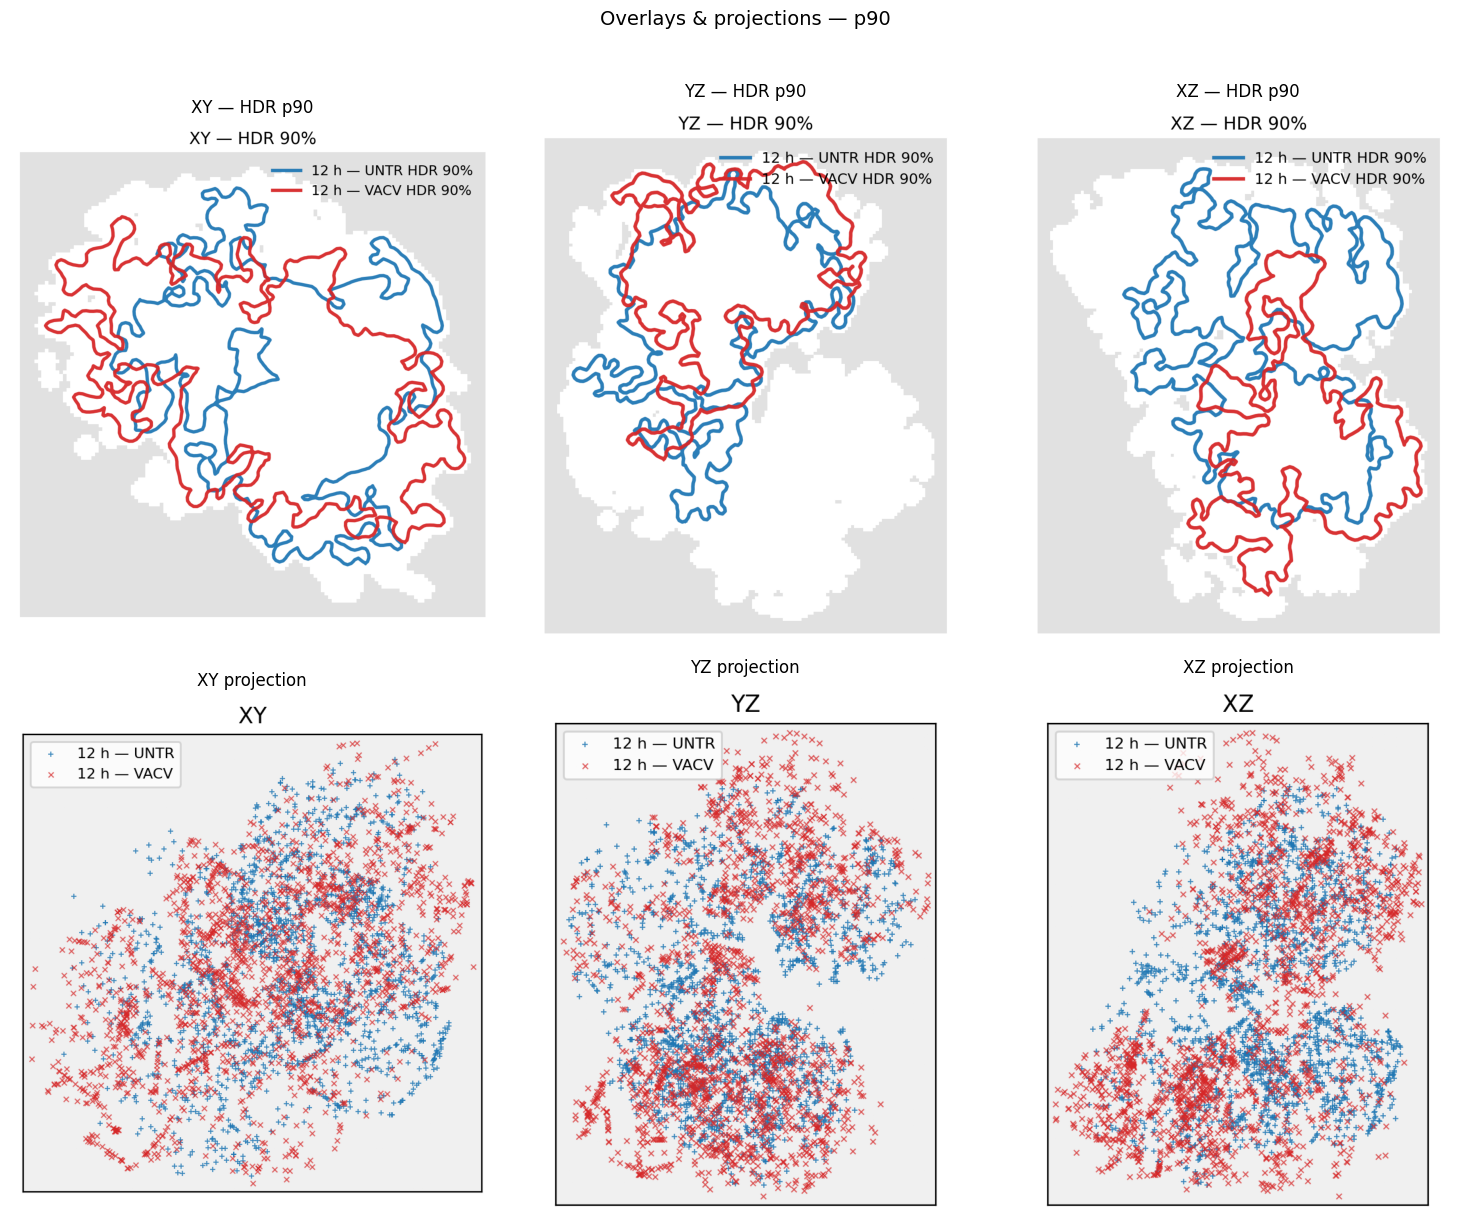

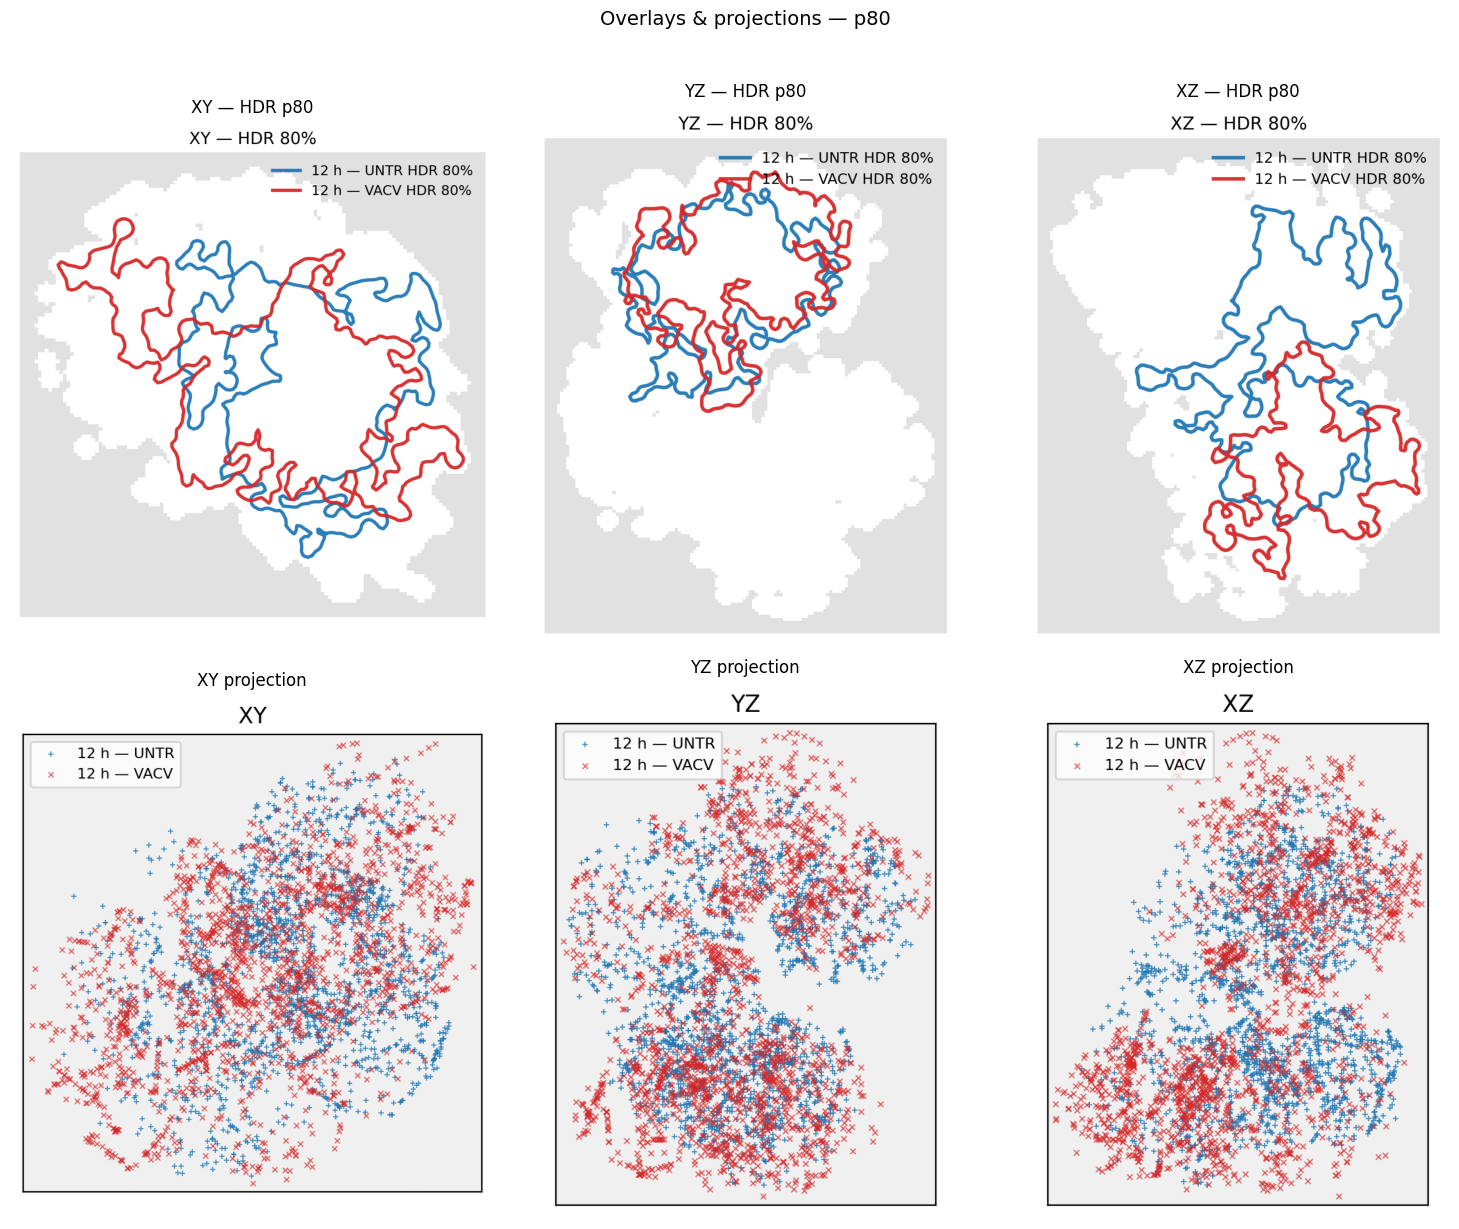

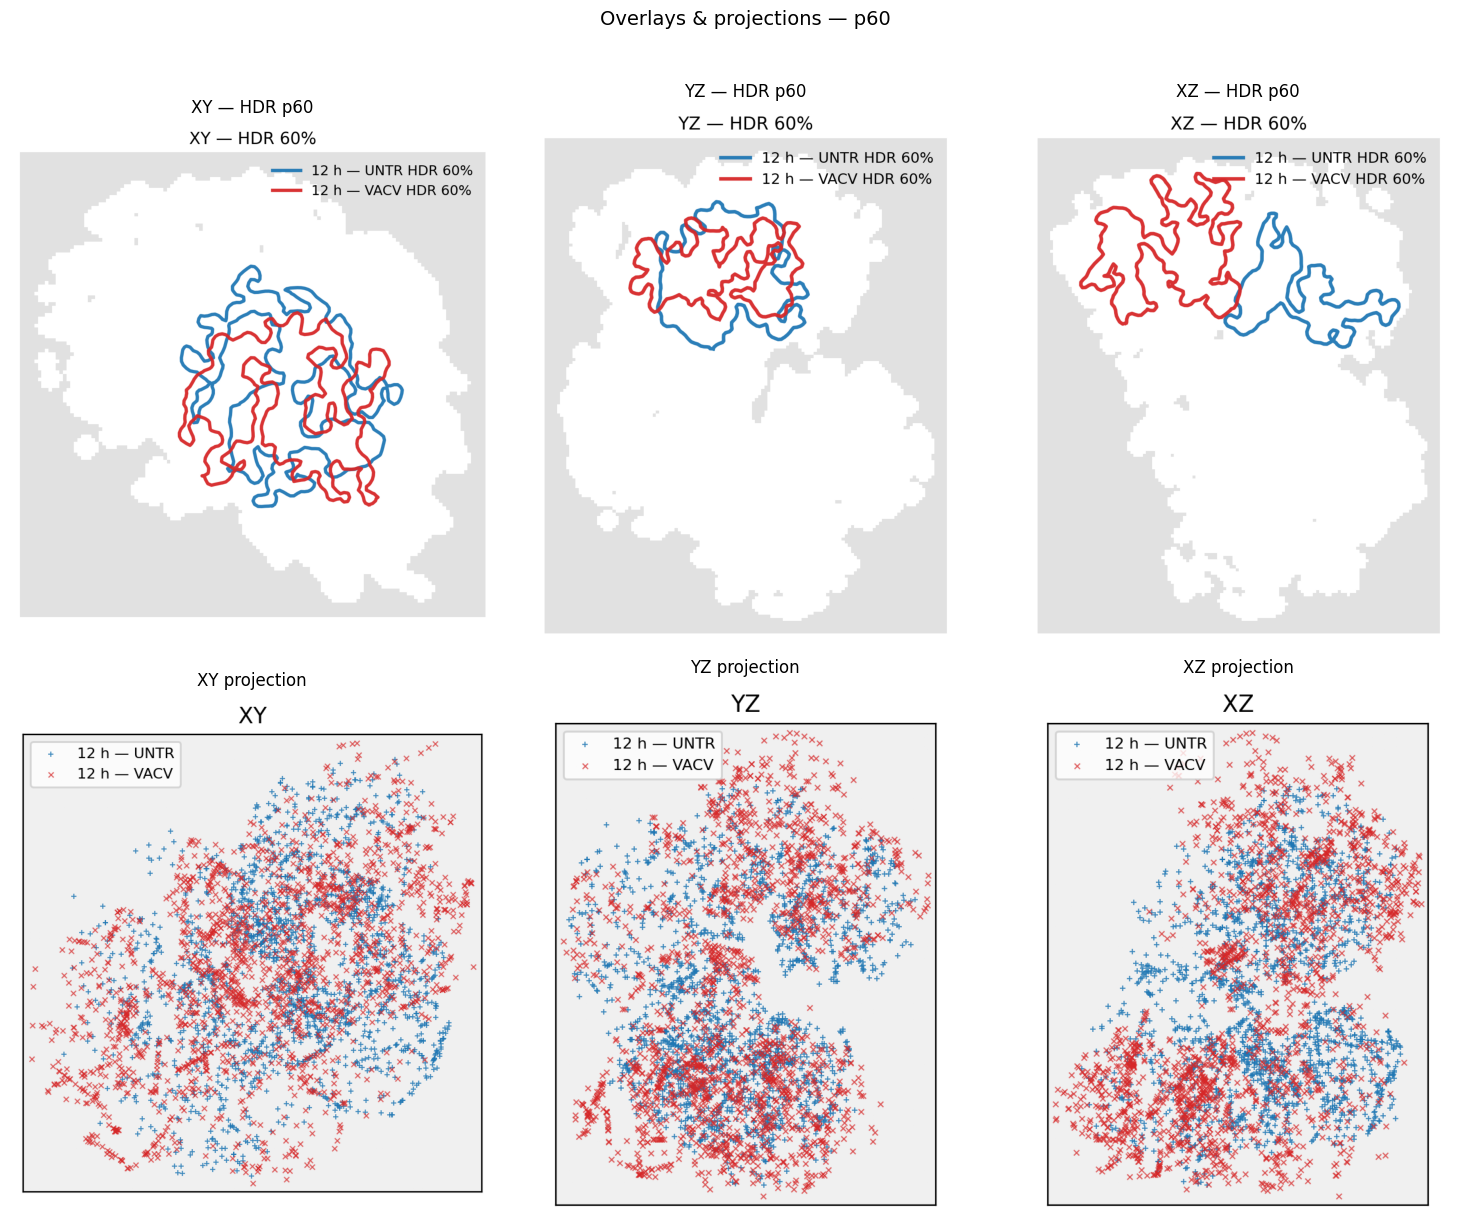

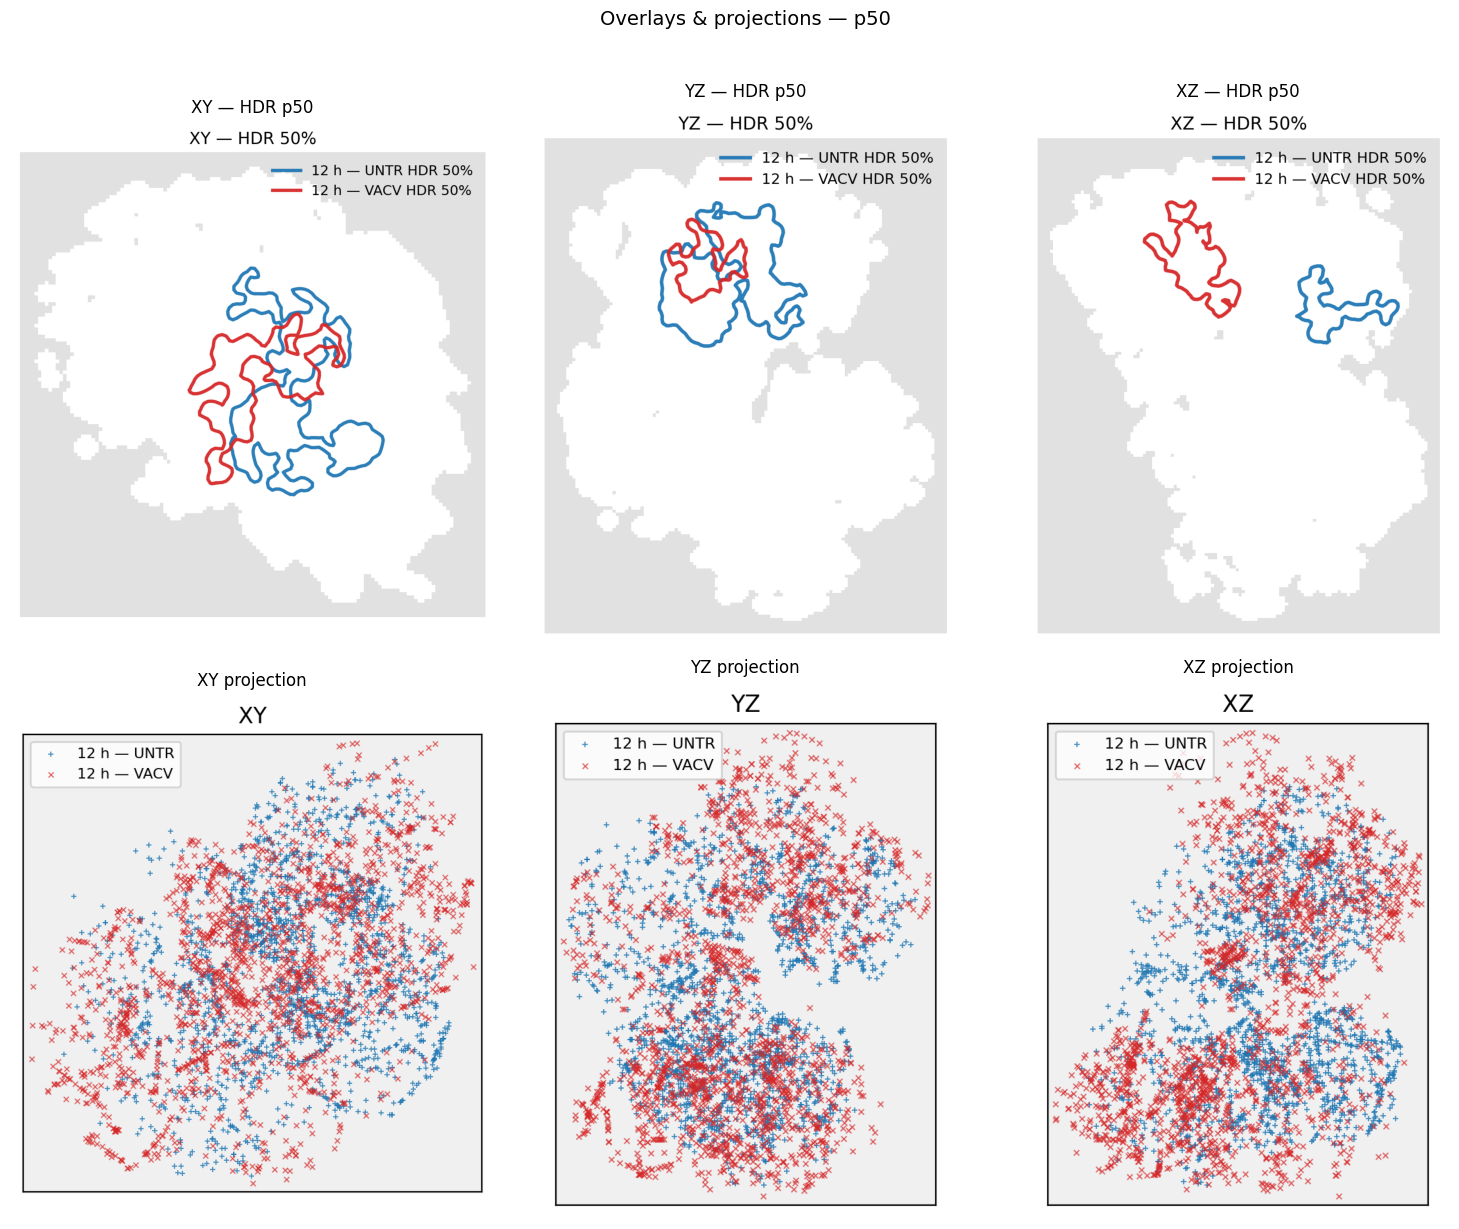

In [5]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg

OUT = "data/green_monkey/va_testing/out_chr1_12h_untr_vs_vacv_hdr"

def _first_existing(*paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def show_bands_and_projections(levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
                               planes=("XY","YZ","XZ"),
                               out_dir=OUT,
                               show_bands_row=False,
                               save=False,
                               save_dir=None,
                               dpi=180):
    """
    For each level in `levels`, show a panel:
      - If p==100:
          Row 1: support p100 overlays
          Row 2: HDR p100 overlays
          Row 3: point projections
          Row 4 (optional): HDR bands
      - Else:
          Row 1: HDR overlays
          Row 2: point projections
          Row 3 (optional): HDR bands
    """
    for p in levels:
        p_int = int(round(p*100))
        ptag = f"p{p_int}"

        # dynamic row count
        if p_int == 100:
            nrows = 4 if show_bands_row else 3
        else:
            nrows = 3 if show_bands_row else 2

        fig, axs = plt.subplots(nrows, len(planes),
                                figsize=(15, 12 if nrows <= 3 else 15))

        # make axs always 2D
        if nrows == 1:
            axs = np.array([axs])
        if axs.ndim == 1:
            axs = axs[None, :]

        row_idx = 0

        # --- Row 1: support p100 overlays (only if p==100) ---
        if p_int == 100:
            for col, plane in enumerate(planes):
                ax = axs[row_idx, col]
                support_path = os.path.join(out_dir, f"overlay_{plane}_p100_support.png")
                if os.path.exists(support_path):
                    ax.imshow(mpimg.imread(support_path))
                    ax.set_title(f"{plane} — support p100", fontsize=12)
                else:
                    ax.text(0.5, 0.5, f"Missing overlay_{plane}_p100_support.png",
                            ha="center", va="center")
                ax.axis("off")
            row_idx += 1

        # --- HDR overlays ---
        for col, plane in enumerate(planes):
            ax = axs[row_idx, col]
            if p_int == 100:
                overlay_path = _first_existing(
                    os.path.join(out_dir, f"overlay_{plane}_p100_hdr.png"),
                    os.path.join(out_dir, f"overlay_{plane}_p100.png"),
                )
            else:
                overlay_path = _first_existing(
                    os.path.join(out_dir, f"overlay_{plane}_{ptag}_hdr.png"),
                    os.path.join(out_dir, f"overlay_{plane}_{ptag}.png"),
                )
            if overlay_path:
                ax.imshow(mpimg.imread(overlay_path))
                ax.set_title(f"{plane} — HDR {ptag}", fontsize=12)
            else:
                ax.text(0.5, 0.5, f"Missing overlay_{plane}_{ptag}*.png",
                        ha="center", va="center")
            ax.axis("off")
        row_idx += 1

        # --- Point projections ---
        for col, plane in enumerate(planes):
            ax = axs[row_idx, col]
            proj_path = os.path.join(out_dir, f"proj_{plane}.png")
            if os.path.exists(proj_path):
                ax.imshow(mpimg.imread(proj_path))
                ax.set_title(f"{plane} projection", fontsize=12)
            else:
                ax.text(0.5, 0.5, f"Missing proj_{plane}.png",
                        ha="center", va="center")
            ax.axis("off")
        row_idx += 1

        # --- HDR bands (optional) ---
        if show_bands_row:
            for col, plane in enumerate(planes):
                ax = axs[row_idx, col]
                bands_path = os.path.join(out_dir, f"overlay_{plane}_bands_hdr.png")
                if os.path.exists(bands_path):
                    ax.imshow(mpimg.imread(bands_path))
                    ax.set_title(f"{plane} — HDR bands", fontsize=12)
                else:
                    ax.text(0.5, 0.5, f"Missing overlay_{plane}_bands_hdr.png",
                            ha="center", va="center")
                ax.axis("off")

        plt.suptitle(f"Overlays & projections — {ptag}", y=1.02, fontsize=14)
        plt.tight_layout()

        if save:
            os.makedirs(save_dir or out_dir, exist_ok=True)
            out_png = os.path.join(save_dir or out_dir, f"panel_{ptag}.png")
            plt.savefig(out_png, dpi=dpi, bbox_inches="tight")
        plt.show()



# Example: visualize p100, p95, p90, p80, p60, p50; include bands row; save panels
# show_bands_and_projections(show_bands_row=True, save=True, save_dir=OUT)

# Default quick view (no bands row, no saving)
# show_bands_and_projections(show_bands_row=True)
show_bands_and_projections()

Saving projections BEFORE alignment...
Performing PCA and ICP alignment...
Saving projections AFTER alignment...
Displaying comparison...


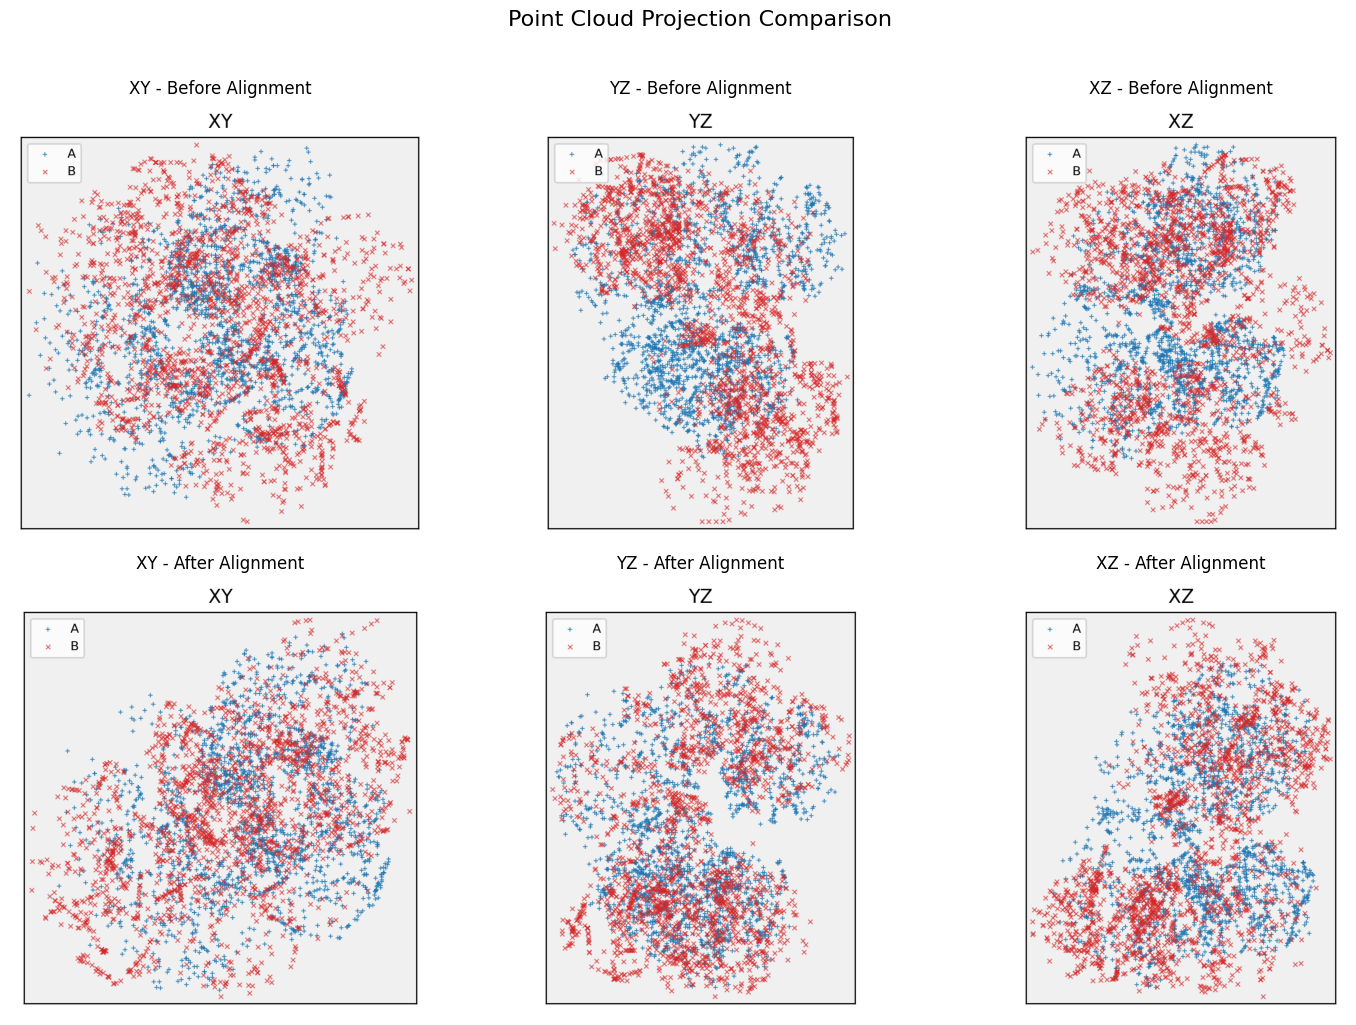

In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

# --- Re-use necessary functions from your original pipeline ---
# IO
def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

# Alignment
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1)
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))
    return rmse

def best_pca_prealign(B_pts, A_pts):
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# Plotting function modified to save to a specific filename
def save_point_projection_like_screenshot(A, B, i, j, plane, out_dir, filename_suffix="", labelA="A", labelB="B"):
    all2 = np.vstack([A[:,[i,j]], B[:,[i,j]]])
    (xmin,ymin) = all2.min(0); (xmax,ymax) = all2.max(0)
    xr, yr = (xmax-xmin), (ymax-ymin); pad = 0.02
    fig, ax = plt.subplots(figsize=(5,4))
    ax.set_facecolor("#f0f0f0")
    ax.scatter(A[:, i], A[:, j], marker="+", s=8, linewidths=0.6, alpha=0.85, c="#1f77b4", label=labelA)
    ax.scatter(B[:, i], B[:, j], marker="x", s=8, linewidths=0.6, alpha=0.75, c="#d62728", label=labelB)
    ax.set_xlim(xmin - pad*xr, xmax + pad*xr)
    ax.set_ylim(ymin - pad*yr, ymax + pad*yr)
    ax.set_aspect("equal","box"); ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(plane); ax.legend(loc="upper left", fontsize=8, frameon=True)
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"proj_{plane}{filename_suffix}.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

# --- Main script to generate and compare images ---
def run_and_compare_projections(csv_A: str, csv_B: str, out_dir: str):
    """
    Loads point clouds, saves 'before' projections, performs alignment,
    saves 'after' projections, and displays them for comparison.
    """
    os.makedirs(out_dir, exist_ok=True)

    # 1) Load & Center
    A_raw, B_raw = load_points(csv_A), load_points(csv_B)
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)
    
    # 2) Save "Before Alignment" projections
    print("Saving projections BEFORE alignment...")
    save_point_projection_like_screenshot(A0, B0, 0, 1, "XY", out_dir, "_raw")
    save_point_projection_like_screenshot(A0, B0, 1, 2, "YZ", out_dir, "_raw")
    save_point_projection_like_screenshot(A0, B0, 0, 2, "XZ", out_dir, "_raw")

    # 3) Align B -> A
    print("Performing PCA and ICP alignment...")
    Rpre = best_pca_prealign(B0, A0)
    B1 = B0 @ Rpre.T
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=30, sample=50000, trim_q=0.10)
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)
    
    # Scale aligned points uniformly
    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    s = float((maxs - mins).max())
    A_scaled, B_scaled = A_al/s, B_al/s
    
    # 4) Save "After Alignment" projections
    print("Saving projections AFTER alignment...")
    save_point_projection_like_screenshot(A_scaled, B_scaled, 0, 1, "XY", out_dir, "_aligned")
    save_point_projection_like_screenshot(A_scaled, B_scaled, 1, 2, "YZ", out_dir, "_aligned")
    save_point_projection_like_screenshot(A_scaled, B_scaled, 0, 2, "XZ", out_dir, "_aligned")

    # 5) Display the results
    print("Displaying comparison...")
    planes = ["XY", "YZ", "XZ"]
    fig, axs = plt.subplots(2, len(planes), figsize=(15, 10))

    for i, plane in enumerate(planes):
        # Before Alignment
        path_raw = os.path.join(out_dir, f"proj_{plane}_raw.png")
        if os.path.exists(path_raw):
            axs[0, i].imshow(mpimg.imread(path_raw))
            axs[0, i].set_title(f"{plane} - Before Alignment", fontsize=12)
        else:
            axs[0, i].set_title(f"Missing {plane} raw image", fontsize=10, color='red')
        axs[0, i].axis("off")

        # After Alignment
        path_aligned = os.path.join(out_dir, f"proj_{plane}_aligned.png")
        if os.path.exists(path_aligned):
            axs[1, i].imshow(mpimg.imread(path_aligned))
            axs[1, i].set_title(f"{plane} - After Alignment", fontsize=12)
        else:
            axs[1, i].set_title(f"Missing {plane} aligned image", fontsize=10, color='red')
        axs[1, i].axis("off")

    plt.suptitle("Point Cloud Projection Comparison", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# --- Configuration and Execution ---
if __name__ == "__main__":
    CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
    CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"
    OUT_DIR = "data/green_monkey/va_testing/out_chr1_12h_untr_vs_vacv_hdr"
    
    # Run the main comparison function
    run_and_compare_projections(CSV_A, CSV_B, OUT_DIR)